In [2]:
%%capture
!git clone https://github.com/qasemii/Noiser.git /content/noiser/
%cd /content/noiser/
!pip install accelerate datasets peft inseq ai2-olmo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd /content/noiser/

import os, re, json
import torch, numpy
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR

from dsets import KnownsDataset
from importance_score_evaluator.utils import (
    check_whitespace,
    collect_token_range,
    match_tokens_with_scores
)

import random
import shutil
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from tqdm import tqdm
import json
from datasets import load_dataset
from pprint import pprint

/content/noiser


In [4]:
from huggingface_hub import login

HF_TOKEN = # Add your HF_TOKEN here
login(HF_TOKEN)

## Noiser "Hello World"

In [3]:
device = "cuda"
random.seed(42)
torch.manual_seed(42)
torch.use_deterministic_algorithms(True, warn_only=True)

torch.set_grad_enabled(False)

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:
from importance_score_evaluator.noiser import  NoiserImportanceScoreEvaluator

model_name = 'Qwen/Qwen2-0.5B'
# model_name = "meta-llama/Llama-3.2-1B"
# model_name = "google/gemma-2-2b"

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

In [6]:
def predict_token(model, tokenizer, prompt):
    inp = tokenizer(prompt, return_tensors='pt').to(device)
    # The following only is True for OLMo models
    if 'token_type_ids' in inp.keys():
        inp.pop('token_type_ids')

    logits = model(**inp)["logits"]
    probs = torch.softmax(logits[:, -1, :], dim=-1)
    probs, preds = torch.max(probs, dim=-1, keepdim=True)  # Keep dims for consistency
    result = tokenizer.decode(preds.squeeze(0).item())
    return result

In [7]:
knowns = KnownsDataset(DATA_DIR)

# Filter dataset to those that the model can predict correctly
knowns = [d for d in tqdm(knowns)
          if predict_token(model, tokenizer, d['prompt']).strip() != d['target']
          ]

data/known_1000.json does not exist. Downloading from https://rome.baulab.info/data/dsets/known_1000.json


100%|██████████| 335k/335k [00:00<00:00, 2.02MB/s]


Loaded dataset with 1209 elements


  0%|          | 0/1209 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/models/qwen2/modeling_qwen2.py:335: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  freqs = (inv_freq_expanded.float().to(x.device) @ position_ids_expanded.float()).transpose(1, 2)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(Tru

In [9]:
idx = 0
prompt = knowns[0]['prompt']
target = knowns[0]['target']

print('-'*10)
print(prompt, target)
print('-'*10)

input_ids = tokenizer(prompt, return_tensors='pt')['input_ids'][0].to(device)
attention_mask = tokenizer(prompt, return_tensors='pt')['attention_mask'][0].to(device)
generated_ids = model.generate(input_ids=torch.unsqueeze(input_ids, 0),
                                attention_mask= torch.unsqueeze(attention_mask, 0),
                                pad_token_id=tokenizer.eos_token_id,
                                max_new_tokens=1,
                                do_sample=False)[0]

----------
Vinson Massif is located in the continent of Antarctica
----------


/usr/local/lib/python3.11/dist-packages/transformers/models/qwen2/modeling_qwen2.py:335: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  freqs = (inv_freq_expanded.float().to(x.device) @ position_ids_expanded.float()).transpose(1, 2)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlg

In [10]:
norm = 'None'
mode = 'prob'

rationalizer = NoiserImportanceScoreEvaluator(
    model=model,
    tokenizer=tokenizer,
    norm=norm,
    mode=mode
)

input_ids = tokenizer(prompt, return_tensors='pt')['input_ids'][0].unsqueeze(0).to(device)
target_id = tokenizer(" "+target, return_tensors='pt')['input_ids'][0].to(device)

rationalizer.rationalize(input_ids, target_id)
scores = rationalizer.mean_important_score.unsqueeze(0).to(device)


input_text = tokenizer.decode(input_ids.squeeze(), skip_special_tokens=True)
tokens = nltk.word_tokenize(input_text)
tokens = ['"' if token in ['``', "''"] else token for token in tokens]
tokens = check_whitespace(input_text, tokens)
tokens_range = collect_token_range(tokenizer, input_text, tokens)
scores = match_tokens_with_scores(scores.squeeze(), tokens_range)

0.0107421875


In [35]:
def plot_rationales(tokens, target, scores, savepdf=None, modelname=None):
    differences = scores.unsqueeze(dim=0)


    # low_score = result["low_score"]
    answer = target

    labels = tokens

    fig, ax = plt.subplots(figsize=(len(labels), 0.5), dpi=200)
    h = ax.pcolor(
        differences, cmap="Greens",
        # vmin=low_score #Setting the minimum value of the color bar to 0
        # vmax=1    # Setting the maximum value of the color bar to 1
    )

    ax.set_xticks([0.5 + i for i in range(len(labels))])
    ax.set_xticklabels(labels, rotation=20, ha='center', fontsize=8)  # , position=(0.1, 0))

    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_position('right')
    ax.set_ylabel(f"[{answer}]", rotation=0, labelpad=30, va='center')

    scores_formatted = [f'{x.item():.4f}' for x in differences[0]]
    for i, label in enumerate(scores_formatted):
        ax.annotate(label, (0.5 + i, 1.0), textcoords="offset points", xytext=(0, -15), ha='center', fontsize=8, rotation=0)

    if savepdf:
        os.makedirs(os.path.dirname(savepdf), exist_ok=True)
        plt.savefig(savepdf, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

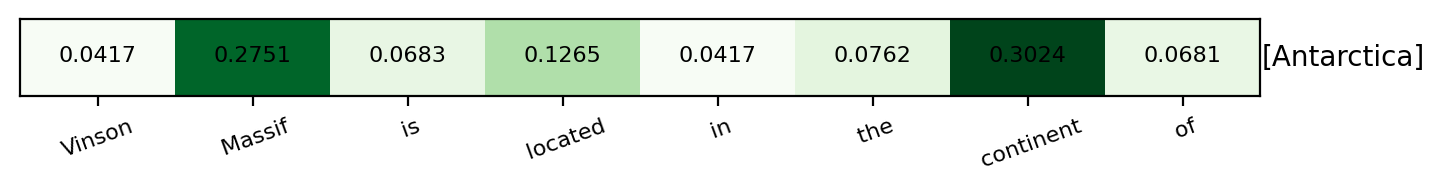

In [36]:
plot_rationales(tokens, target, scores)

## Running the faithfulness evaluation

In [15]:
%cd /content/noiser
model_name = "Qwen/Qwen2-0.5B"
# model_name = "allenai/OLMo-1B"
# model_name = "google/gemma-2-2b"
# model_name = "meta-llama/Llama-3.2-1B"

method = "noiser"
# method = "sequential_integrated_gradients"
# method = "discretized_integrated_gradients"
# method = "attention"

# Only required for Noiser
norm = 'None'

!python main.py\
      --model_name $model_name\
      --method $method\
      --dataset "Knowns"\
      --output_dir "results/"\
      --n_samples -1\
      --norm $norm
      # --max_new_tokens 20


/content/noiser
2025-04-10 16:28:55.480159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744302535.502983   22243 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744302535.509852   22243 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading model and tokenizer ...
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Loading Knowns dataset ...
data/known_1000.json does not exist. Downloading from https://rome.baulab.info/data/dsets/known_1000.json
100% 335k/335k [00:00<00:00, 412kB/s]
Loaded dataset with 1209 elements
Filtering dataset ...
/usr/local/lib/python3.11/dist-packages/transformers/mo

## Running the answerability evaluation

In [ ]:
%cd /content/noiser/
TOGETHER_API_KEY = "80f3a660c2bd5c3902101d1d1977c951c8659d55b2b949ae42e47f8b6d42c6d7"

%cd /content/noiser
model_name = "Qwen/Qwen2-0.5B"
# model_name = "allenai/OLMo-1B"
# model_name = "google/gemma-2-2b"
# model_name = "meta-llama/Llama-3.2-1B"

method = "noiser"
# method = "sequential_integrated_gradients"
# method = "discretized_integrated_gradients"
# method = "attention"

# Only required for Noiser
norm = 'None'

!python answerability.py\
      --model_name $model_name\
      --method $method\
      --norm $norm\
      --n_samples 10\
      --openai_api_key $TOGETHER_API_KEY